In [1]:
import pandas as pd
import torch
from torch.nn import Linear, Sigmoid, BCEWithLogitsLoss
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.transforms import AddSelfLoops, ToDense
from data import MoleculeDataset
import random
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'data'

In [8]:
train_path = '~/github/MolNet/raw_data/sider_data/train_sider.csv'
val_path = '~/github/MolNet/raw_data/sider_data/val_sider.csv'
test_path = '~/github/MolNet/raw_data/sider_data/test_sider.csv'

In [44]:
data_path = '~/github/MolNet/raw_data/sider_data/sider.csv'
sider_data = pd.read_csv(data_path)
X = sider_data.loc[:,'smiles']
y = sider_data.iloc[:,1:]

In [55]:
# split
random.seed(22)
all_data_size = sider_data.shape[0]
train_ind = random.sample(list(sider_data.index),int(all_data_size*0.7))
train_data = sider_data.loc[train_ind,:]
leftover = sider_data.loc[[i for i in range(all_data_size) if i not in train_ind],:]
val_ind = random.sample(list(leftover.index),int(len(leftover.index)*0.333))
val_data = leftover.loc[val_ind,:]
test_data = leftover.loc[[i for i in list(leftover.index) if i not in val_ind],:]

train_data = train_data.reset_index().drop('index',axis=1)
val_data = val_data.reset_index().drop('index',axis=1)
test_data = test_data.reset_index().drop('index',axis=1)

In [256]:
from skmultilearn.model_selection import iterative_train_test_split
X_v = np.matrix(X.values).T
y_v = np.matrix(y.values)
X_train, y_train, X_test, y_test = iterative_train_test_split(X_v,y_v,test_size = 0.2)

In [258]:
X_train.shape

(1136, 1)

In [71]:
train_dataset = MoleculeDataset(train_data, transform=AddSelfLoops())
val_dataset = MoleculeDataset(val_data, transform=AddSelfLoops())
test_dataset = MoleculeDataset(test_data, transform=AddSelfLoops())

In [72]:
train_dataset[0]

Molecule(edge_index=[2, 52], x=[16, 4], y=[1, 27])

In [117]:
train_dataloader = DataLoader(train_dataset,batch_size=50,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=50,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=50,shuffle=True)

In [74]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#### MODEL #####
class Net(torch.nn.Module):
    def __init__(self, num_node_features: int, num_classes: int):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.lin1 = Linear(16,100)
        self.lin2 = Linear(100,num_classes)
        self.sig = Sigmoid()

    def forward(self, data):
        x, edge_index, batch_vec = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        sum_vector = global_add_pool(x,batch = batch_vec)
        x = F.relu(sum_vector)
        x = F.dropout(x, training=self.training)
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.lin2(x)

        return x

In [100]:
num_node_features = 4
num_classes = train_dataset[0].y.size(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_node_features, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

num_epochs = 30

criterion = BCEWithLogitsLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    
    print(f'Epoch {epoch}:')
    model.train()

    train_running_loss = 0.0
    train_running_accuracy = 0.0
    
    for inputs in train_dataloader:

        optimizer.zero_grad()
        with torch.set_grad_enabled(mode=True):
            out = model(inputs)
            train_loss = criterion(out, inputs.y)
            train_acc = ((torch.sigmoid(out)>0.5).numpy()==inputs.y.numpy()).mean()
            train_loss.backward()
            optimizer.step()
            
        train_running_loss += train_loss.item() * inputs.y.size(0)
        train_running_accuracy += train_acc * inputs.y.size(0)
        
    epoch_train_loss = train_running_loss/len(train_dataset)
    train_losses.append(epoch_train_loss)
    epoch_train_acc = train_running_accuracy/len(train_dataset)
    train_accuracies.append(epoch_train_acc)
    
    print(f'Train:\nLoss = {epoch_train_loss}\nAcc = {epoch_train_acc}')   
    
    model.eval()

    val_running_loss = 0.0
    val_running_accuracy = 0.0
    
    for inputs in val_dataloader:

        with torch.set_grad_enabled(mode=False):
            out = model(inputs)
            val_loss = criterion(out, inputs.y)
            val_acc = ((torch.sigmoid(out)>0.5).numpy()==inputs.y.numpy()).mean()
            
        val_running_loss += val_loss.item() * inputs.y.size(0)
        val_running_accuracy += val_acc * inputs.y.size(0)
        
    epoch_val_loss = val_running_loss/len(val_dataset)
    val_losses.append(epoch_val_loss)
    epoch_val_acc = val_running_accuracy/len(val_dataset)
    val_accuracies.append(epoch_val_acc) 
    
    print(f'Validation:\nLoss = {epoch_val_loss}\nAcc = {val_accuracies}')

KeyboardInterrupt: 

In [105]:
val_accuracies

[0.7201356285863328,
 0.7378716744913929,
 0.7344809598330725,
 0.7425665101721439,
 0.7425665101721439,
 0.742566510172144,
 0.7425665101721439,
 0.7425665101721438,
 0.7425665101721438,
 0.7425665101721439,
 0.7425665101721439,
 0.742566510172144,
 0.7425665101721439,
 0.742566510172144,
 0.7425665101721438,
 0.7425665101721438,
 0.7425665101721439,
 0.7383933229003652,
 0.742566510172144,
 0.7425665101721439,
 0.742566510172144,
 0.7425665101721438,
 0.7425665101721439,
 0.7425665101721438,
 0.742566510172144,
 0.7425665101721439,
 0.742566510172144]

In [96]:
len(train_dataset)

998

In [97]:
len(val_dataset)

142

In [98]:
len(test_dataset)

287

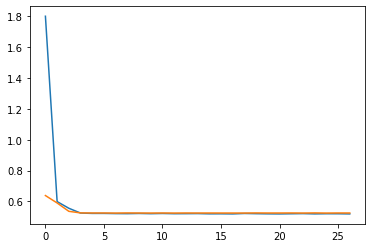

In [113]:
import matplotlib.pyplot as plt
plt.plot(list(range(27)),train_losses)
plt.plot(list(range(27)),val_losses)

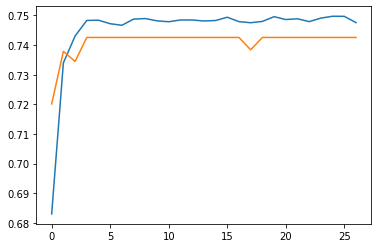

In [114]:
import matplotlib.pyplot as plt
plt.plot(list(range(27)),train_accuracies)
plt.plot(list(range(27)),val_accuracies)

In [144]:
import time
latencies=[]
all_probs=np.array([])
all_labels=np.array([])
for test_batch in test_dataloader:
    since = time.time()
    model.eval()
    with torch.set_grad_enabled(mode=False):
        pred=model(test_batch)
        probs = torch.sigmoid(pred).numpy()
        lbls = test_batch.y.numpy()
        if all_probs.size>0:
            all_probs = np.vstack([all_probs,probs])
        else:
            all_probs = probs
        if all_labels.size>0:
            all_labels = np.vstack([all_labels,lbls])
        else:
            all_labels = lbls
    latencies.append(time.time() - since)

In [134]:
np.mean([l/50 for l in latencies])

0.00013757944107055666

In [147]:
from sklearn.metrics import auc
from scipy import interp
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(27):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

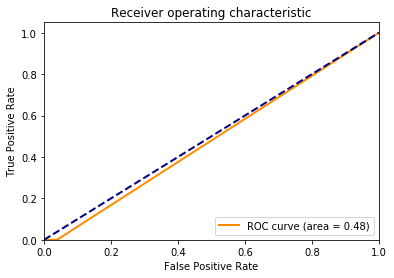

In [161]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

/Users/mbluestone/opt/anaconda3/envs/molnet/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


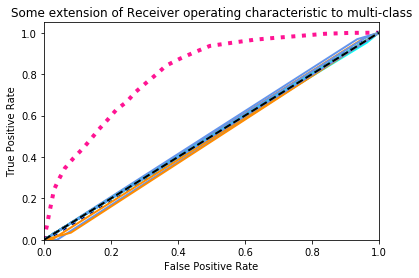

In [191]:
from itertools import cycle
n_classes=27
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
#plt.legend(loc="lower right")
plt.show()

In [158]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [189]:
from sklearn.metrics import f1_score,precision_score,recall_score,roc_curve
from collections import defaultdict

scores=defaultdict(lambda: dict.fromkeys(['dist','f1','p','r']))
for i in range(27):
    scores[i]['dist'] = np.round(all_labels[:,i].mean(),decimals=2)
    scores[i]['f1'] = np.round(f1_score(all_labels[:, i], all_probs[:, i]>0.5),decimals=2)
    scores[i]['p'] = np.round(precision_score(all_labels[:, i], all_probs[:, i]>0.5),decimals=2)
    scores[i]['r'] = np.round(recall_score(all_labels[:, i], all_probs[:, i]>0.5),decimals=2)

/Users/mbluestone/opt/anaconda3/envs/molnet/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [190]:
scores

defaultdict(<function __main__.<lambda>()>,
            {0: {'dist': 0.51, 'f1': 0.67, 'p': 0.51, 'r': 1.0},
             1: {'dist': 0.69, 'f1': 0.82, 'p': 0.69, 'r': 1.0},
             2: {'dist': 0.01, 'f1': 0.0, 'p': 0.0, 'r': 0.0},
             3: {'dist': 0.65, 'f1': 0.79, 'p': 0.65, 'r': 1.0},
             4: {'dist': 0.81, 'f1': 0.9, 'p': 0.81, 'r': 1.0},
             5: {'dist': 0.7, 'f1': 0.82, 'p': 0.7, 'r': 1.0},
             6: {'dist': 0.91, 'f1': 0.95, 'p': 0.91, 'r': 1.0},
             7: {'dist': 0.15, 'f1': 0.0, 'p': 0.0, 'r': 0.0},
             8: {'dist': 0.68, 'f1': 0.81, 'p': 0.68, 'r': 1.0},
             9: {'dist': 0.47, 'f1': 0.64, 'p': 0.47, 'r': 1.0},
             10: {'dist': 0.23, 'f1': 0.0, 'p': 0.0, 'r': 0.0},
             11: {'dist': 0.91, 'f1': 0.95, 'p': 0.91, 'r': 1.0},
             12: {'dist': 0.22, 'f1': 0.0, 'p': 0.0, 'r': 0.0},
             13: {'dist': 0.15, 'f1': 0.0, 'p': 0.0, 'r': 0.0},
             14: {'dist': 0.78, 'f1': 0.88, 'p': 0.78, 

In [168]:
means=[]
for i in range(27):
    means.append(all_labels[:,i].mean())

In [195]:
dists = defaultdict(lambda: dict.fromkeys(['count','proportion']))
for i in range(27):
    dists[i]['count'] = np.round(all_labels[:,i].sum(),decimals=2)
    dists[i]['proportion'] = np.round(all_labels[:,i].mean(),decimals=2)
    #dists[i]['f1'] = np.round(f1_score(all_labels[:, i], all_probs[:, i]>0.5),decimals=2)
dists

defaultdict(<function __main__.<lambda>()>,
            {0: {'count': 145.0, 'proportion': 0.51},
             1: {'count': 199.0, 'proportion': 0.69},
             2: {'count': 3.0, 'proportion': 0.01},
             3: {'count': 186.0, 'proportion': 0.65},
             4: {'count': 233.0, 'proportion': 0.81},
             5: {'count': 201.0, 'proportion': 0.7},
             6: {'count': 261.0, 'proportion': 0.91},
             7: {'count': 44.0, 'proportion': 0.15},
             8: {'count': 194.0, 'proportion': 0.68},
             9: {'count': 136.0, 'proportion': 0.47},
             10: {'count': 65.0, 'proportion': 0.23},
             11: {'count': 261.0, 'proportion': 0.91},
             12: {'count': 63.0, 'proportion': 0.22},
             13: {'count': 42.0, 'proportion': 0.15},
             14: {'count': 225.0, 'proportion': 0.78},
             15: {'count': 180.0, 'proportion': 0.63},
             16: {'count': 262.0, 'proportion': 0.91},
             17: {'count': 40.0, 'prop

In [243]:
def get_pos_weights(data):
    '''
    
    '''

    labels = data.iloc[:,1:].values
    weights = [(labels.shape[0]-labels[:,i].sum())/labels[:,i].sum() 
               for i in range(labels.shape[1])]
    return torch.tensor(weights)

get_pos_weights(train_data)


tensor([ 0.9010,  0.4360, 61.3750,  0.6442,  0.2413,  0.4298,  0.0943,  4.3369,
         0.3690,  0.9492,  2.8385,  0.1089,  3.4356,  5.4805,  0.2828,  0.6097,
         0.0824,  4.3085,  0.4096,  0.3289,  0.3978,  0.5473,  9.6170,  1.1189,
         0.4443,  0.0919,  0.4698])

In [240]:
train_labels.shape[1]

27

In [214]:
from itertools import chain, combinations

def powerset(iterable):
    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    xs = list(iterable)
    # note we return an iterator rather than a list
    return [list(combinations(xs,n)) for n in range(len(xs)+1)]

In [219]:
[item for sublist in powerset([1,2,3]) for item in sublist]

[(1,), (2,), (3,), (1, 2), (1, 3), (2, 3), (1, 2, 3)]

In [221]:

import random
from collections import defaultdict
class Sampler():
    def __init__(self, data, categories):
        self.D = data
        self.L = categories
        
        # Calculate imbalance levels
        self.IRLbl_l, self.IRMean = self.calculate_IRs(self.D, self.L)
        
    def calculate_IRs(self, D, L):
        # IRLbl(y)
        label_counts = [0]*len(L)
        for instance, active_labels in D:
            for l in active_labels:
                l_index = L.index(l)
                label_counts[l_index] += 1

        max_label_count = float(max(label_counts))

        IRLbl_l = []
        for i in range(len(L)):
            IRLbl_l.append(max_label_count/label_counts[i])

        IRMean = sum(IRLbls)/len(IRLbls)

        return IRLbl_l, IRMean 
    
    def calculate_SCUMBLES(self):
        # SCUMBLE
        scumbles = []
        for instance, active_labels in self.D:
            IRLbli = map(self.get_IRLbl, active_labels) 
            IRLbli_bar = sum(IRLbli)/len(IRLbli)
            IRLbli_prod = (reduce(lambda x,y:x*y, IRLbli))

            scumblei = 1 - (IRLbli_prod ** (1/len(self.L))) / IRLbli_bar
            scumbles.append(scumblei)

        SCUMBLE = sum(scumbles)/len(scumbles)
        return scumbles, SCUMBLE

    def get_IRLbl(self, x): 
        return self.IRLbl_l[self.L.index(x)] 
    
    def REMEDIAL(self):
        # Calculate SCUMBLE
        SCUMBLE_ins, SCUMBLE = self.calculate_SCUMBLES()
        
        # Edit dataset
        new_D = self.D[:] # copy dataset
        for i in range(len(new_D)):
            if SCUMBLE_ins[i] > SCUMBLE:
                instance, labels = new_D[i]
                # Maintain minority labels
                min_labels = filter(lambda x: self.get_IRLbl(x) > self.IRMean, labels)
                maj_labels = filter(lambda x: self.get_IRLbl(x) <= self.IRMean, labels)

                new_D[i] = (instance, min_labels)
                Di = (instance, maj_labels)
                new_D.append(Di)

        return new_D

    
    def ML_ROS(self, P):
        label_to_instance_map = defaultdict(list)
        for instance, labels in self.D:
            for l in labels:
                label_to_instance_map[l].append((instance, labels))
        
        num_samples_to_clone = int(len(self.D)*(P/(100.)))
        print(num_samples_to_clone)
        
        min_bags = {
            l:ins for l,ins in label_to_instance_map.items()
            if self.get_IRLbl(l) > self.IRMean
        }
        
        new_D = self.D
        while num_samples_to_clone > 0:
            # Clone a random sample from each minority bag
            labels_to_remove = []
            for l in min_bags:
                instance_to_clone = random.choice(min_bags[l])
                new_D.append(instance_to_clone)
                
                new_IRs, _ = self.calculate_IRs(new_D, self.L)
                new_IR_l = new_IRs[self.L.index(l)]

                if new_IR_l <= self.IRMean:
                    # Exclude from cloning
                    labels_to_remove.append(l)
                    
                num_samples_to_clone -= 1
      
            for l in labels_to_remove:
                del min_bags[l]
            
            if len(min_bags.keys()) == 0:
                print("Unable to clone all samples. {} left to clone".format(num_samples_to_clone))
                break
                
        return new_D

In [ ]:
sampler = Sampler(train_data.smiles, train_data)

In [274]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix
print(classification_report(all_labels, all_probs>0.5))
                     #labels = train_data.columns[1:].tolist())

In [276]:
classes = train_data.columns[1:].tolist()
for i in range(len(classes)):
    print(classes[i],':')
    print(confusion_matrix(all_labels[:,i], all_probs[:,i]>0.5))

In [283]:
from sklearn.metrics import roc_auc_score
roc_auc_score(all_labels, all_probs>0.5)

0.5

In [2]:
preds = pd.read_csv('/Users/mbluestone/Downloads/graph_test_predictions.csv')

In [3]:
preds

,Unnamed: 0,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,...,"Congenital, familial and genetic disorders",Infections and infestations,"Respiratory, thoracic and mediastinal disorders",Psychiatric disorders,Renal and urinary disorders,"Pregnancy, puerperium and perinatal conditions",Ear and labyrinth disorders,Cardiac disorders,Nervous system disorders,"Injury, poisoning and procedural complications"
0,0,0.499477,0.499636,0.501859,0.498852,0.500818,0.499617,0.500475,0.498825,0.499041,...,0.499048,0.499704,0.499887,0.499081,0.49977,0.498667,0.49971,0.49983,0.496708,0.50052
1,1,0.499477,0.499636,0.501859,0.498852,0.500818,0.499617,0.500475,0.498825,0.499041,...,0.499048,0.499704,0.499887,0.499081,0.49977,0.498667,0.49971,0.49983,0.496708,0.50052
2,2,0.499477,0.499636,0.501859,0.498852,0.500818,0.499617,0.500475,0.498825,0.499041,...,0.499048,0.499704,0.499887,0.499081,0.49977,0.498667,0.49971,0.49983,0.496708,0.50052
3,3,0.499477,0.499636,0.501859,0.498852,0.500818,0.499617,0.500475,0.498825,0.499041,...,0.499048,0.499704,0.499887,0.499081,0.49977,0.498667,0.49971,0.49983,0.496708,0.50052
4,4,0.499477,0.499636,0.501859,0.498852,0.500818,0.499617,0.500475,0.498825,0.499041,...,0.499048,0.499704,0.499887,0.499081,0.49977,0.498667,0.49971,0.49983,0.496708,0.50052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,294,0.499477,0.499636,0.501859,0.498852,0.500818,0.499617,0.500475,0.498825,0.499041,...,0.499048,0.499704,0.499887,0.499081,0.49977,0.498667,0.49971,0.49983,0.496708,0.50052
295,295,0.499477,0.499636,0.501859,0.498852,0.500818,0.499617,0.500475,0.498825,0.499041,...,0.499048,0.499704,0.499887,0.499081,0.49977,0.498667,0.49971,0.49983,0.496708,0.50052
296,296,0.499477,0.499636,0.501859,0.498852,0.500818,0.499617,0.500475,0.498825,0.499041,...,0.499048,0.499704,0.499887,0.499081,0.49977,0.498667,0.49971,0.49983,0.496708,0.50052
297,297,0.499477,0.499636,0.501859,0.498852,0.500818,0.499617,0.500475,0.498825,0.499041,...,0.499048,0.499704,0.499887,0.499081,0.49977,0.498667,0.49971,0.49983,0.496708,0.50052
